# RTP Forecasting

In [1]:
import argparse
import os
import random
import numpy as np
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt

import sys 
import scipy.io
import math
from datetime import date       

import imageio

import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Lambda, LSTM
from tensorflow.keras.layers import concatenate, Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l1_l2


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-11-30 16:26:39.412042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
# Plot history and future
def plot_predictions(pred , actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred)), np.array(pred),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred)), np.array(actual),label='PF', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [7]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [8]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [9]:
raw_DAP

,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST
2015-01-01 05:00:00+00:00,33.45,21.89,31.27,20.84,31.14,43.73,22.68,31.40,31.45,20.06,20.77
2015-01-01 06:00:00+00:00,26.90,21.06,26.34,20.19,26.25,41.16,21.76,26.41,26.49,20.00,19.98
2015-01-01 07:00:00+00:00,25.00,19.64,24.40,18.83,24.35,37.69,20.27,24.49,24.54,18.72,18.61
2015-01-01 08:00:00+00:00,24.39,18.39,23.51,17.60,23.44,31.52,18.97,23.59,23.64,17.35,17.45
2015-01-01 09:00:00+00:00,25.00,18.39,23.99,17.57,23.92,30.00,18.97,24.07,24.10,17.23,17.46
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 00:00:00+00:00,33.09,29.00,33.46,28.22,33.01,39.61,30.13,33.25,33.49,28.38,27.64
2022-01-01 01:00:00+00:00,30.61,27.62,31.28,26.84,30.83,38.01,28.70,31.07,31.28,27.20,26.22
2022-01-01 02:00:00+00:00,29.49,27.55,30.41,26.89,29.99,36.29,28.55,30.24,30.49,27.28,26.20
2022-01-01 03:00:00+00:00,29.63,25.37,29.62,24.71,29.25,30.36,26.26,29.49,29.73,24.72,24.27


In [10]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [11]:
raw_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [12]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [13]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [14]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [15]:
# # Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


### Reshape to (samples, steps, features)

In [16]:
n_steps_in = 24
n_steps_out = 24

x_train_cnn_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn_lstm.shape,y_train_cnn_lstm.shape,x_test_cnn_lstm.shape,y_test_cnn_lstm.shape)



(35017, 24, 3) (35017, 24, 1) (8713, 24, 3) (8713, 24, 1)


In [34]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs


In [35]:
# define model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn_lstm.shape[1],x_train_cnn_lstm.shape[2]), activation=activation))
cnn_lstm_model.add(MaxPooling1D(pool_size))
cnn_lstm_model.add(LSTM(n_lstm_unit, activation=activation))
cnn_lstm_model.add(Dense(100, activation='linear'))
cnn_lstm_model.add(Dense(n_steps_out, activation='linear'))
cnn_lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cnn_lstm_model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 12, 20)            200       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 20)            0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 25)                4600      
                                                                 
 dense_14 (Dense)            (None, 100)               2600      
                                                                 
 dense_15 (Dense)            (None, 24)                2424      
                                                                 
Total params: 9,824
Trainable params: 9,824
Non-trainable params: 0
___________________________________________________

In [26]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_lstm_model.fit(x_train_cnn_lstm, y_train_cnn_lstm, 
                                batch_size = minibatch_size,
                                epochs = num_epochs,
                                validation_split=0.2, verbose=1,
                                callbacks=[early_stop])

Epoch 1/50
438/438 [==============================] - 3s 4ms/step - loss: 0.6983 - val_loss: 0.2062
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 0.6137 - val_loss: 0.2078
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5998 - val_loss: 0.2069
Epoch 4/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5925 - val_loss: 0.2050
Epoch 5/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5838 - val_loss: 0.2089
Epoch 6/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5777 - val_loss: 0.2267
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5709 - val_loss: 0.2046
Epoch 8/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5653 - val_loss: 0.2064
Epoch 9/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5620 - val_loss: 0.1985
Epoch 10/50
438/438 [==============================] - 1s 3ms/step - loss: 0.5579 - val_loss: 0.1971

In [27]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [28]:
cnn_lstm_model.save(os.path.join(model_path,'cnn_lstm_model_24h_nov30.h5'))

### Evaluate

In [39]:
# reload the saved model
# cnn_model = load_model(os.path.join(model_path,'cnn_model_nov23.h5'))

y_test_pred = cnn_lstm_model.predict(x_test_cnn_lstm)


271/271 [==============================] - 1s 2ms/step


In [40]:
# Evaluation metrics
errors = y_test_pred - y_test_cnn_lstm[:,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.5414
RMSE: 0.8200


In [41]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred[::24,:] - y_test_cnn_lstm[::24,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.5491
RMSE: 0.8384


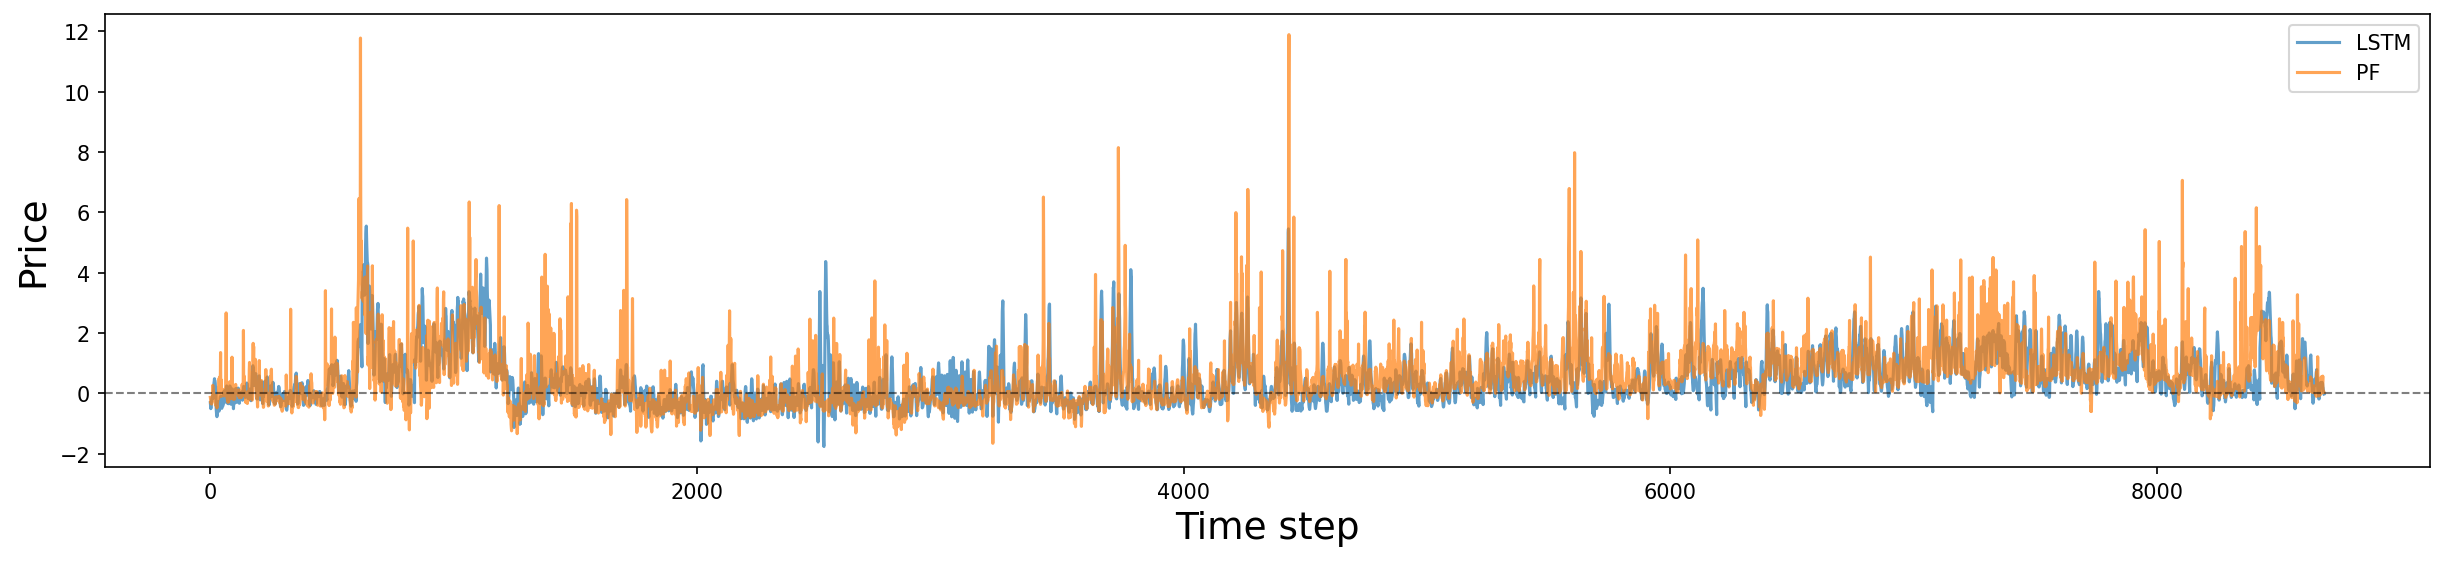

In [42]:
plot_predictions(y_test_pred[::24,:].flatten(), y_test_cnn_lstm[::24,:,0].flatten(), '')

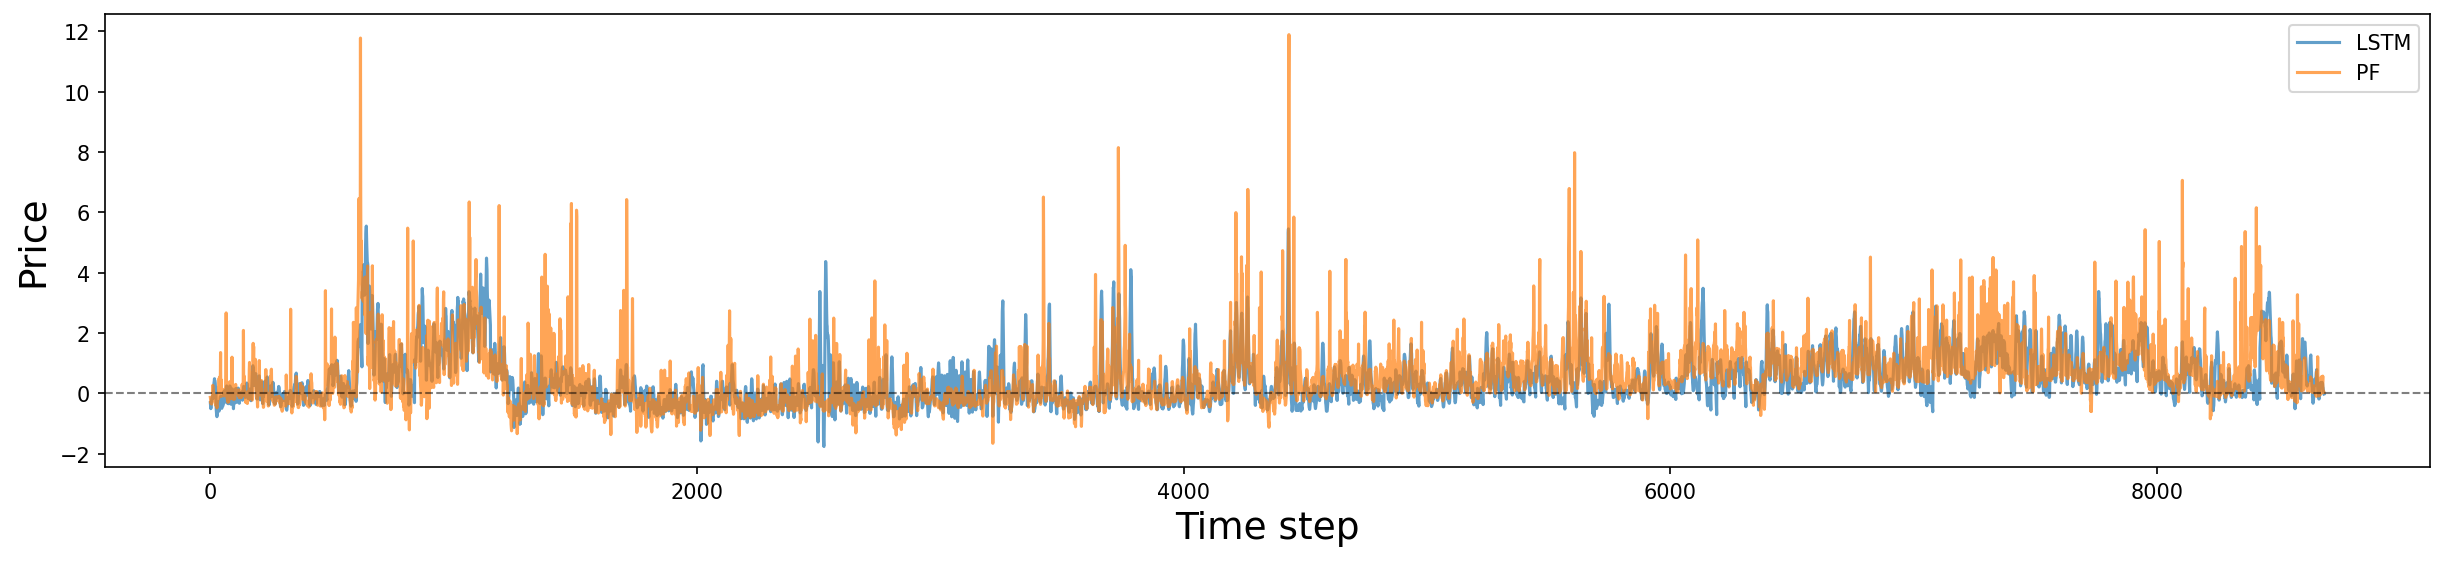

In [43]:
plot_predictions(y_test_pred[::24,:].flatten(), y_test_cnn_lstm[::24,:,0].flatten(), '')

### Rescale and evaluate performance

In [44]:
y_test_pred_rescale = y_test_pred*y_std.values + y_mean.values
y_test_cnn_lstm_rescale = y_test_cnn_lstm*y_std.values + y_mean.values

y_test_pred_invlog = np.exp(y_test_pred_rescale) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_lstm_invlog = np.exp(y_test_cnn_lstm_rescale) -1 + min(raw_data.loc[:,"RTP"])

Hour Ahead Evaluation
MAE: 10.0918
RMSE: 20.4062
24-Hours Ahead Evaluation
MAE: 12.8284
RMSE: 19.2752


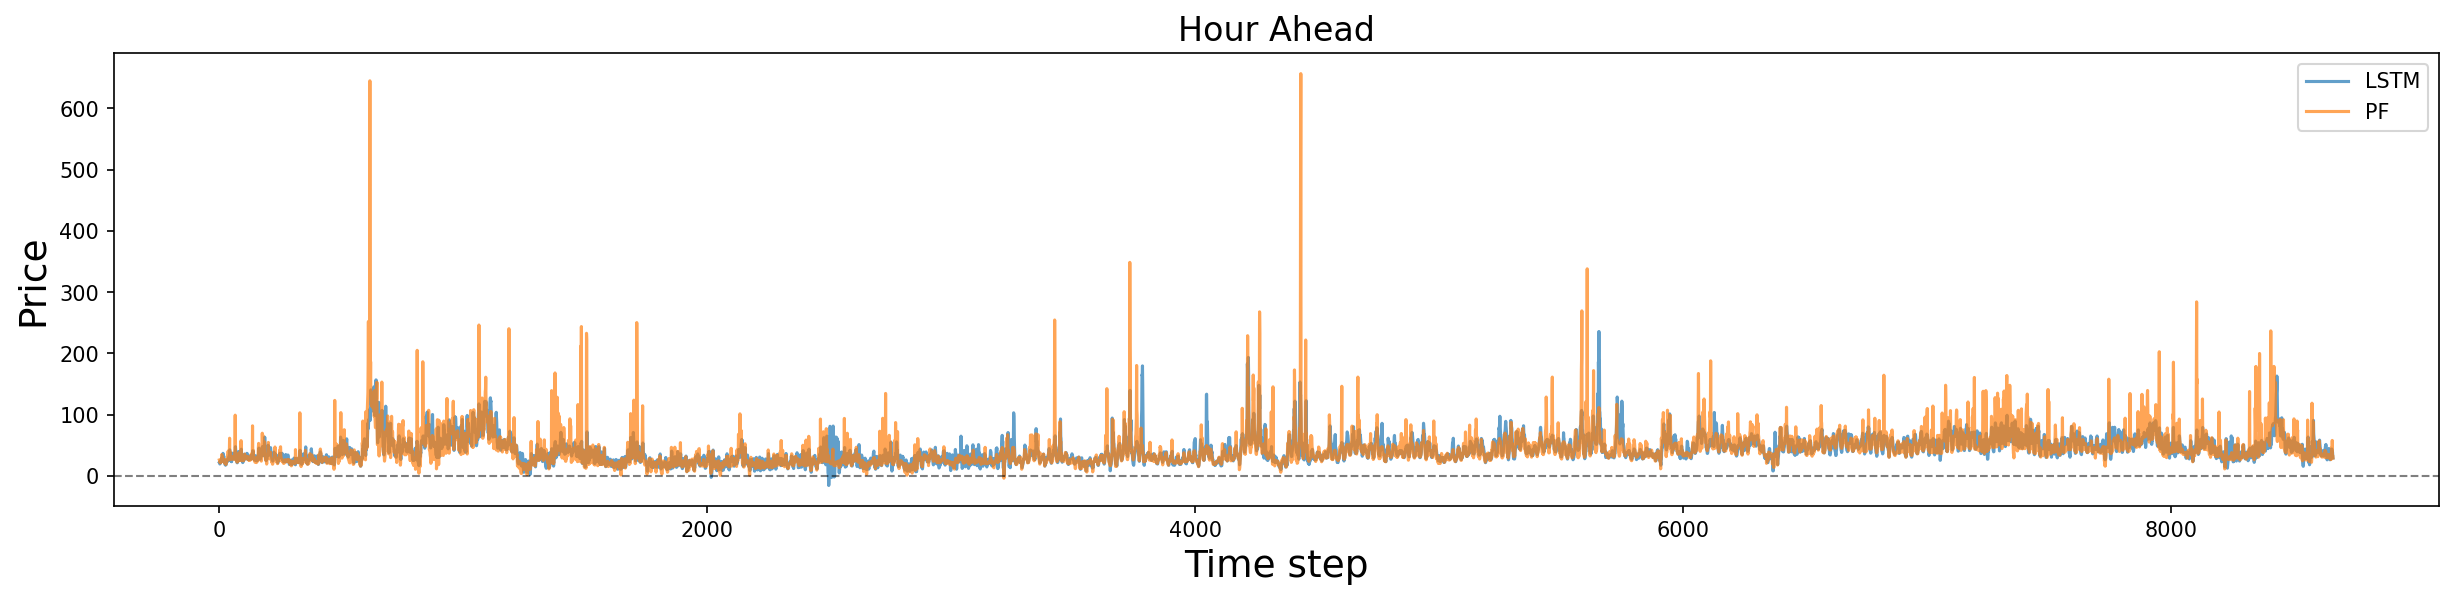

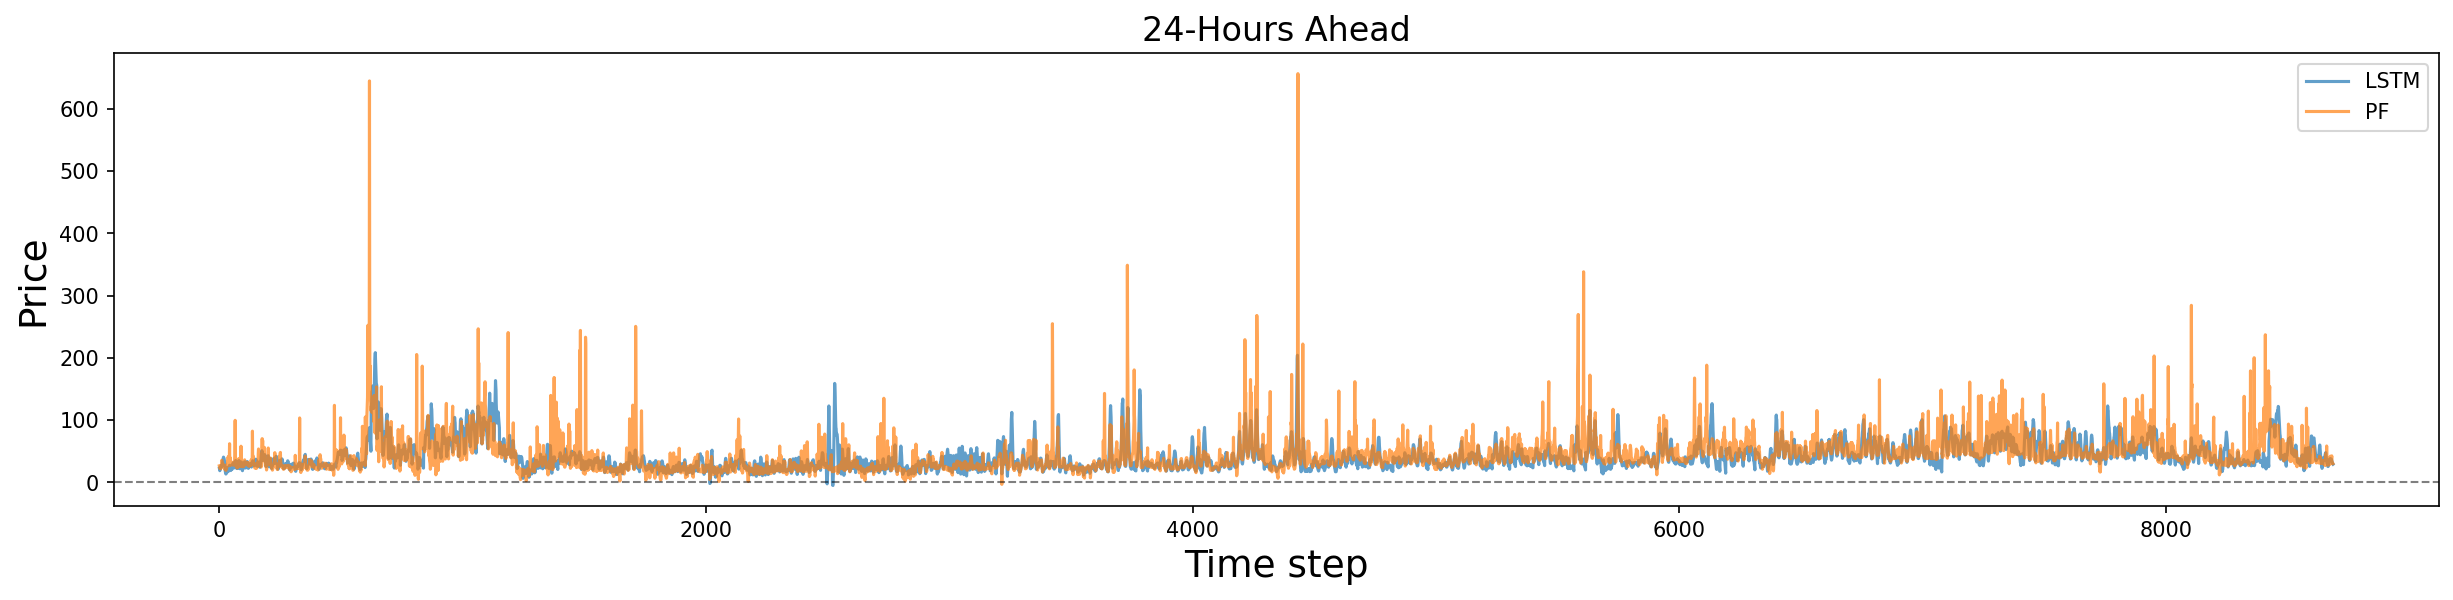

In [45]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred_invlog[:,0] - y_test_cnn_lstm_invlog[:,0,0]
print('Hour Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

errors = y_test_pred_invlog[::24,:] - y_test_cnn_lstm_invlog[::24,0,:]
print('24-Hours Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

plot_predictions(y_test_pred_invlog[:,0].flatten(), y_test_cnn_lstm_invlog[:,0,0].flatten(), 'Hour Ahead')
plot_predictions(y_test_pred_invlog[::24,:].flatten(), y_test_cnn_lstm_invlog[::24,:,0].flatten(), '24-Hours Ahead')


Hour Ahead Evaluation
MAE: 10.0918
RMSE: 20.4062
24-Hours Ahead Evaluation
MAE: 12.8284
RMSE: 19.2752


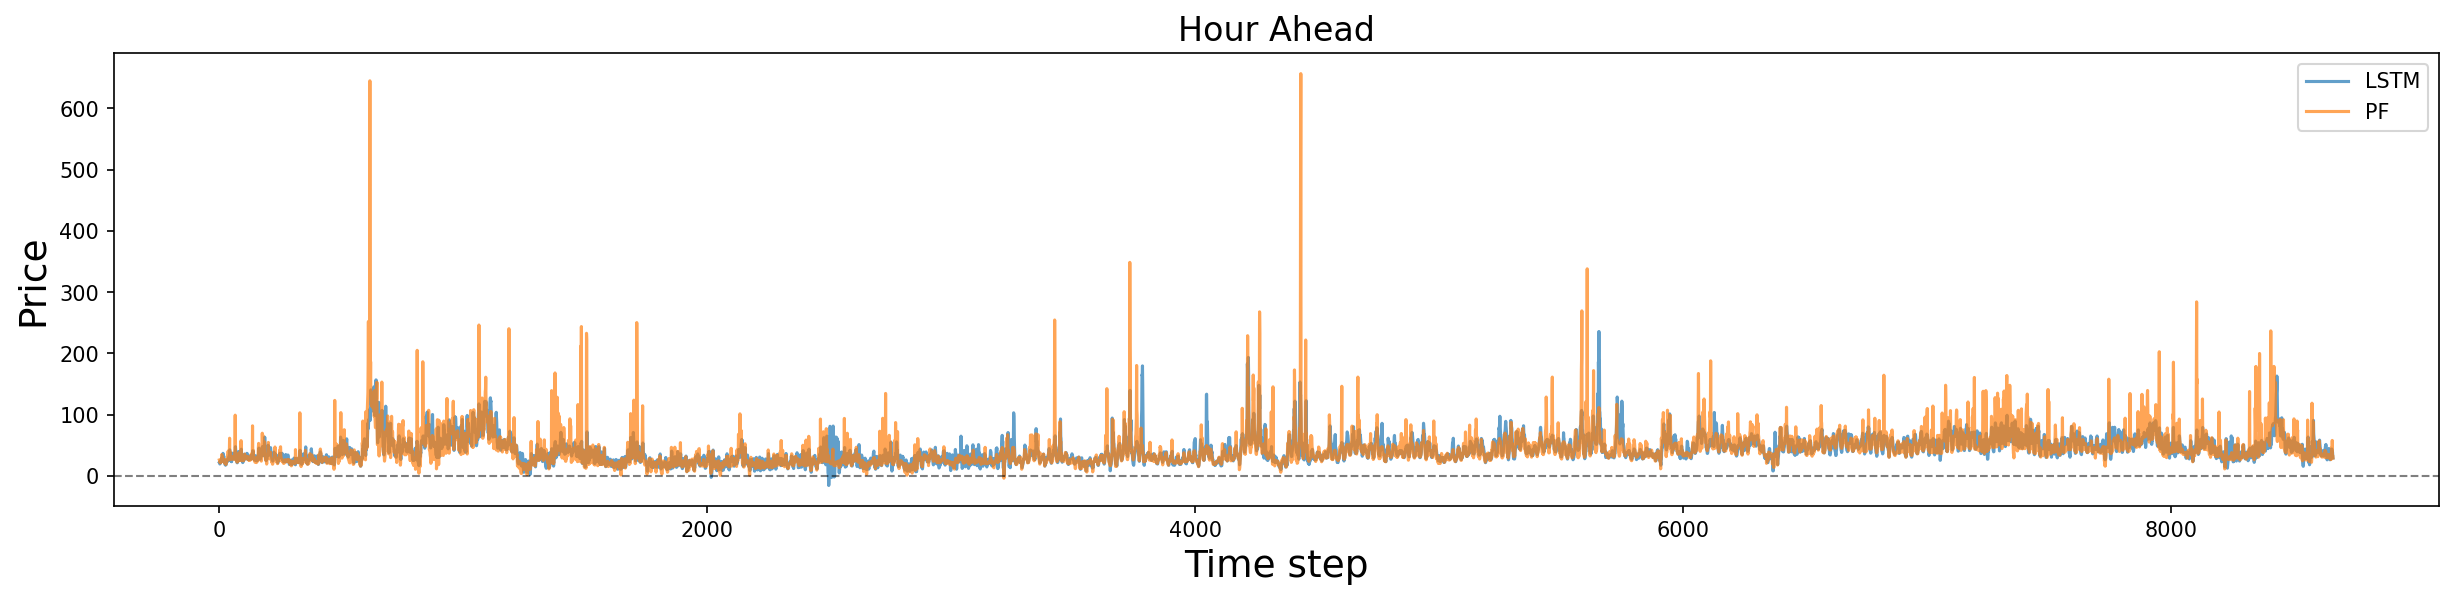

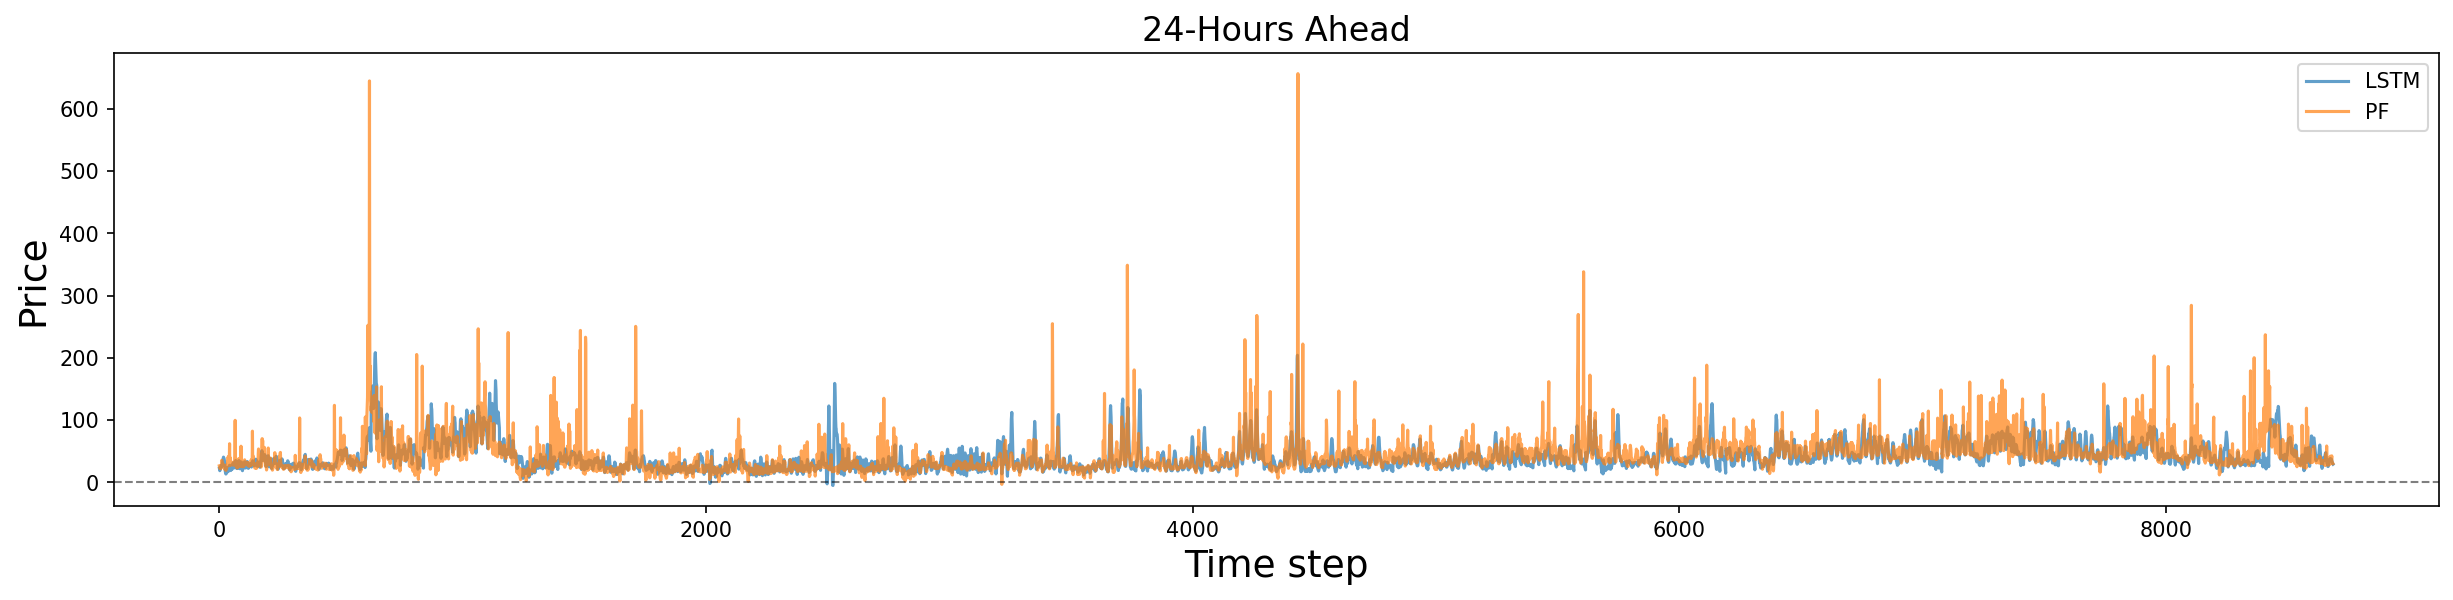

In [46]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred_invlog[:,0] - y_test_cnn_lstm_invlog[:,0,0]
print('Hour Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

errors = y_test_pred_invlog[::24,:] - y_test_cnn_lstm_invlog[::24,0,:]
print('24-Hours Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

plot_predictions(y_test_pred_invlog[:,0].flatten(), y_test_cnn_lstm_invlog[:,0,0].flatten(), 'Hour Ahead')
plot_predictions(y_test_pred_invlog[::24,:].flatten(), y_test_cnn_lstm_invlog[::24,:,0].flatten(), '24-Hours Ahead')


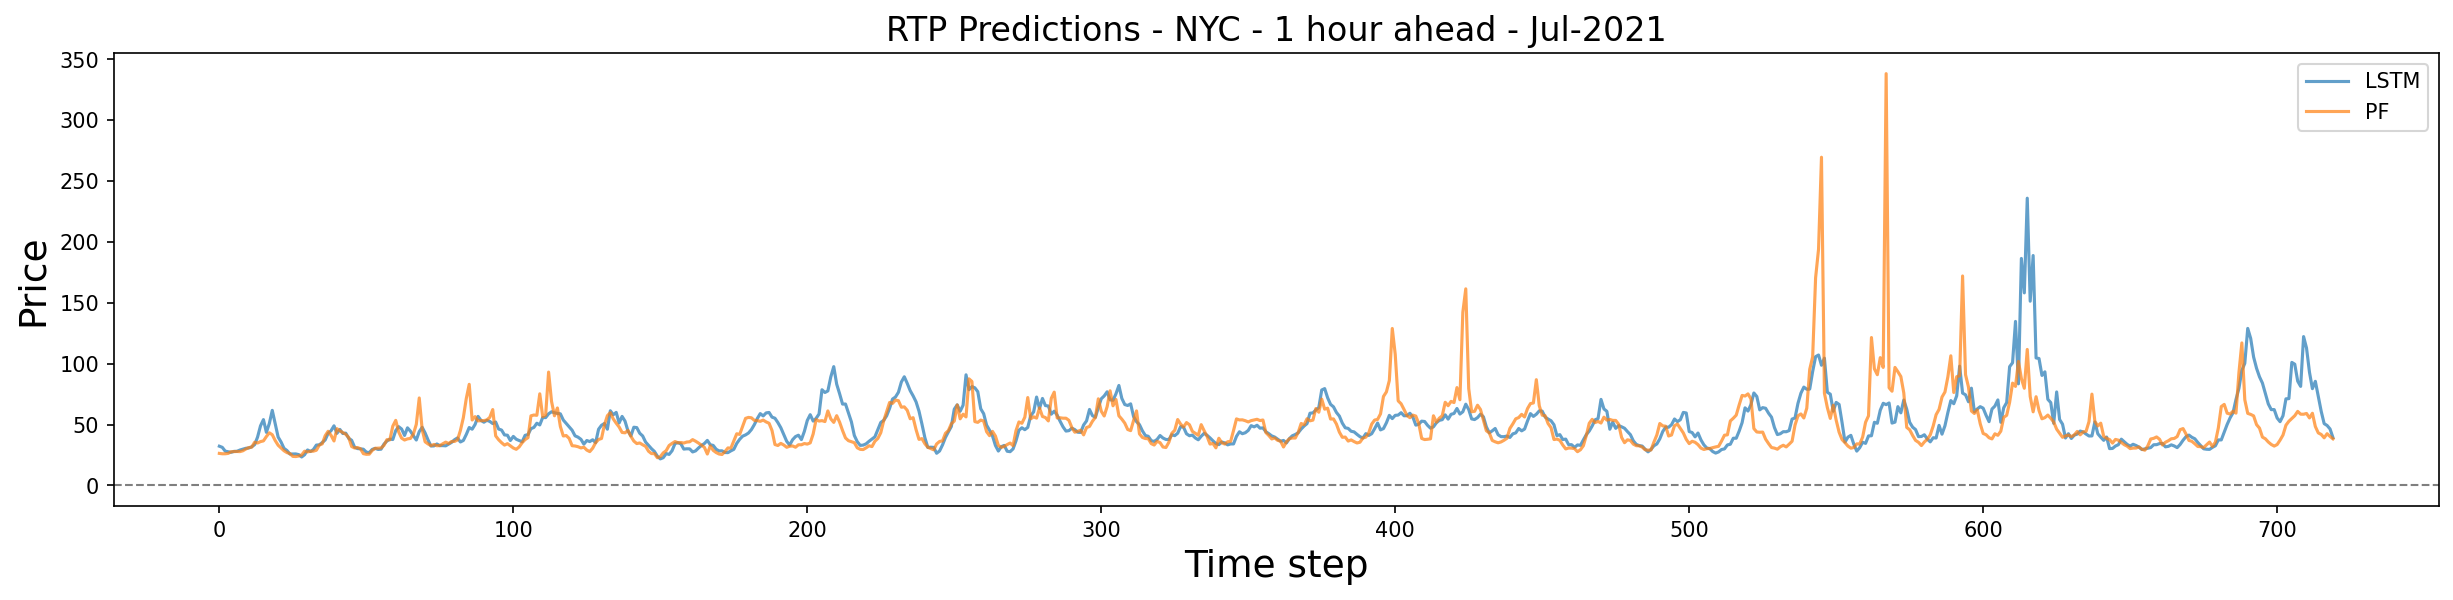

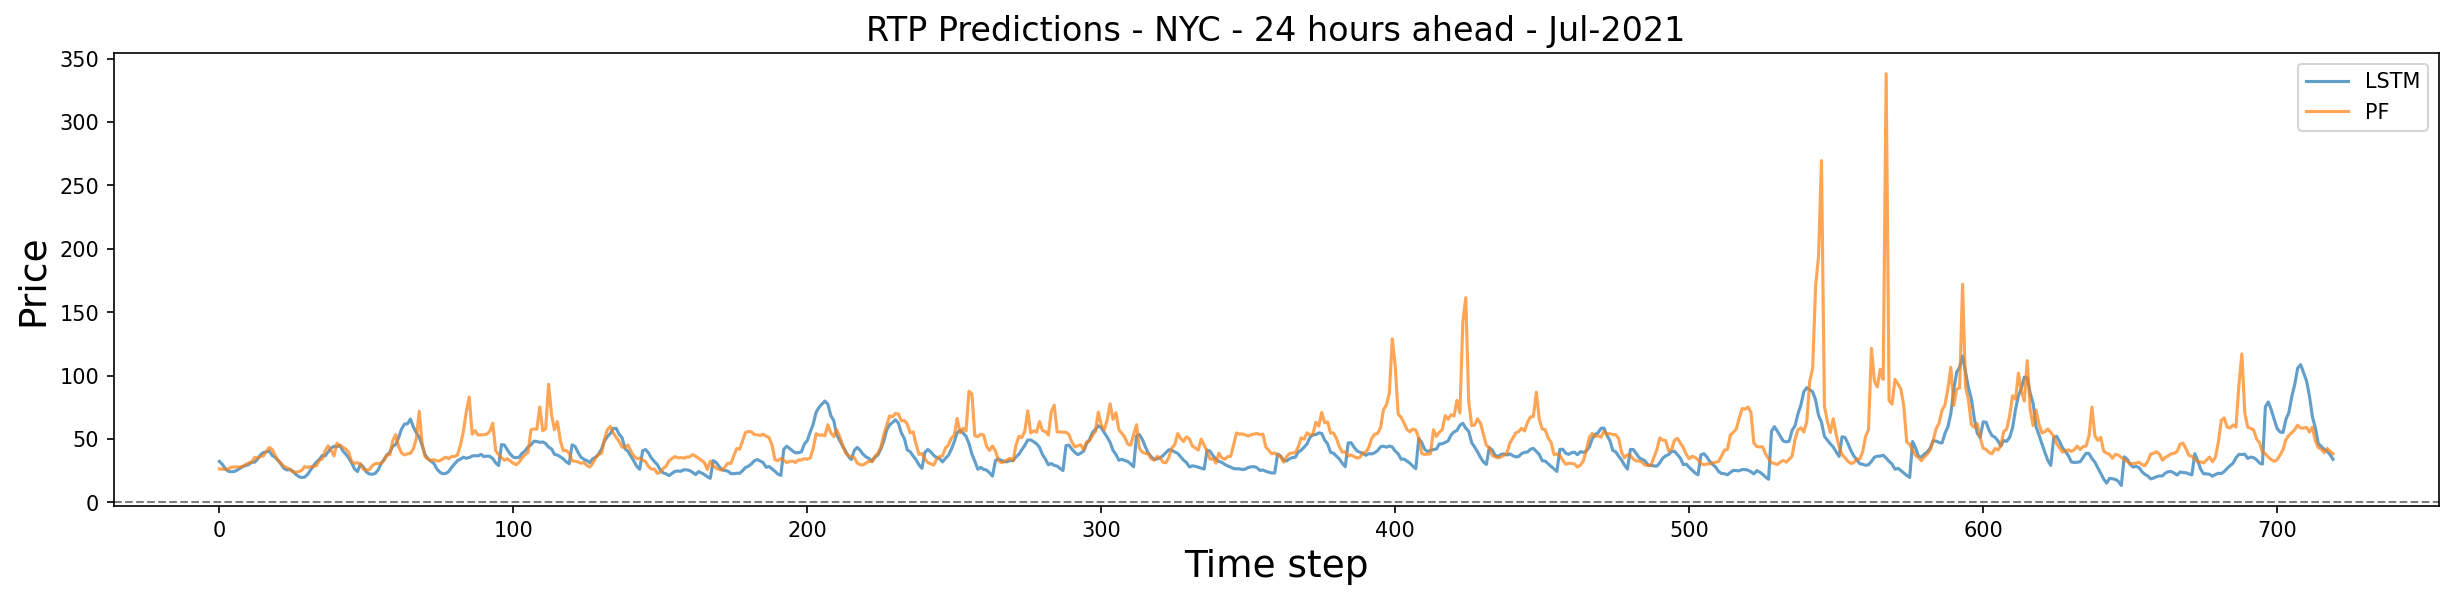

In [47]:
i = 7*24*30
j = i + 24*30

plot_predictions(y_test_pred_invlog[i:j,0].flatten(),
               y_test_cnn_lstm_invlog[i:j,0,0].flatten(),
               'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions(y_test_pred_invlog[i:j:24,:].flatten(),
               y_test_cnn_lstm_invlog[i:j:24,:].flatten(),
               'RTP Predictions - NYC - 24 hours ahead - Jul-2021')


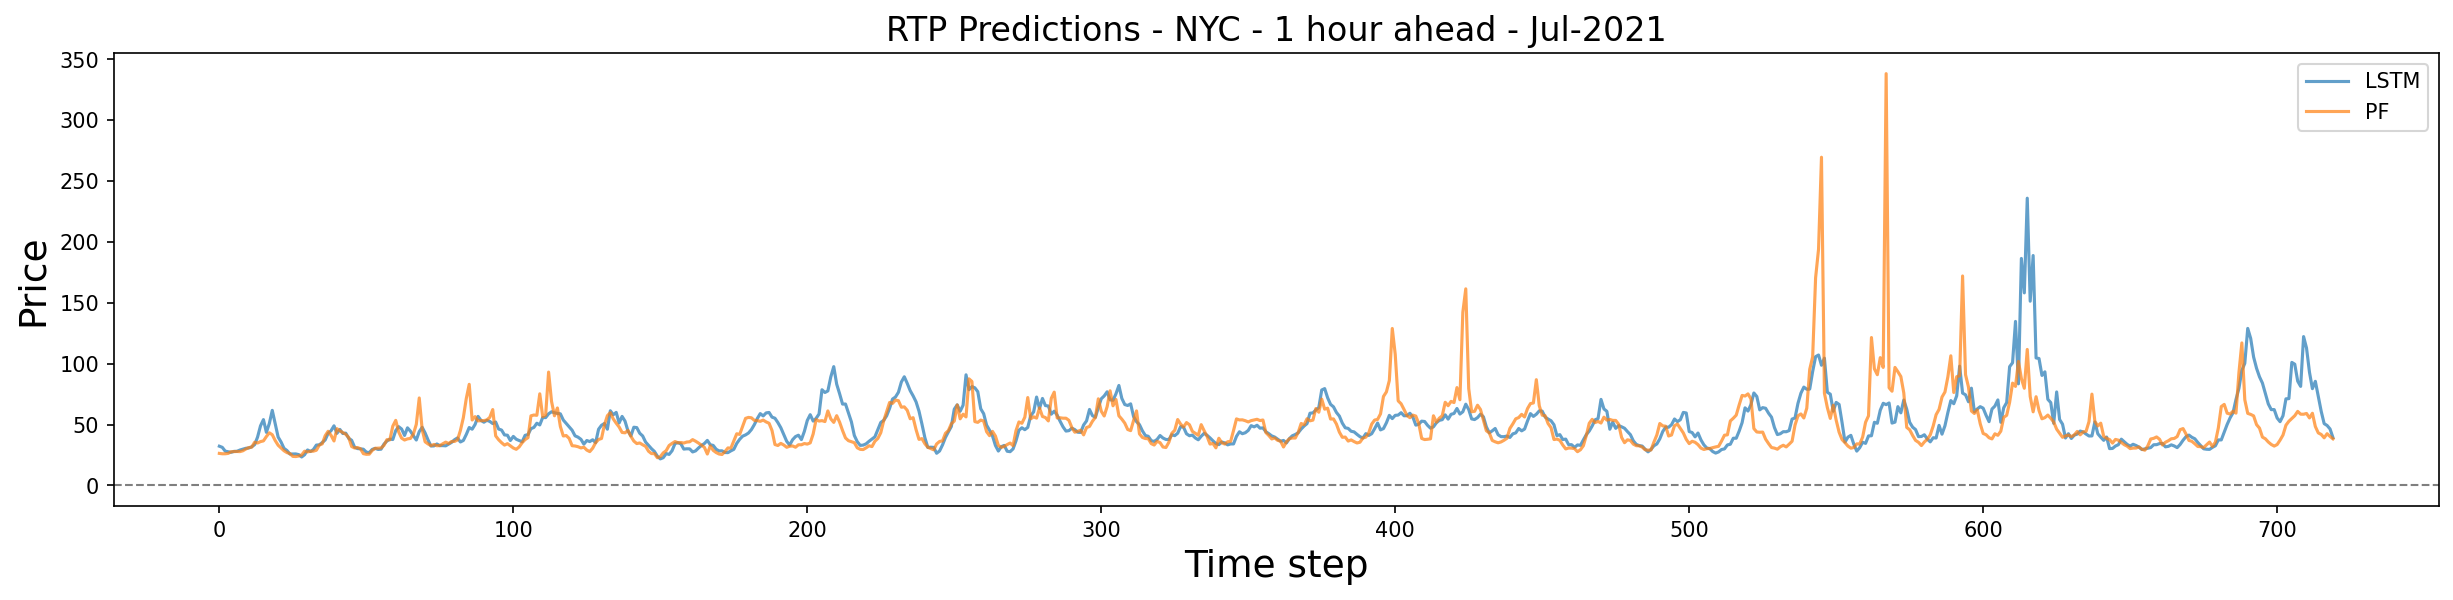

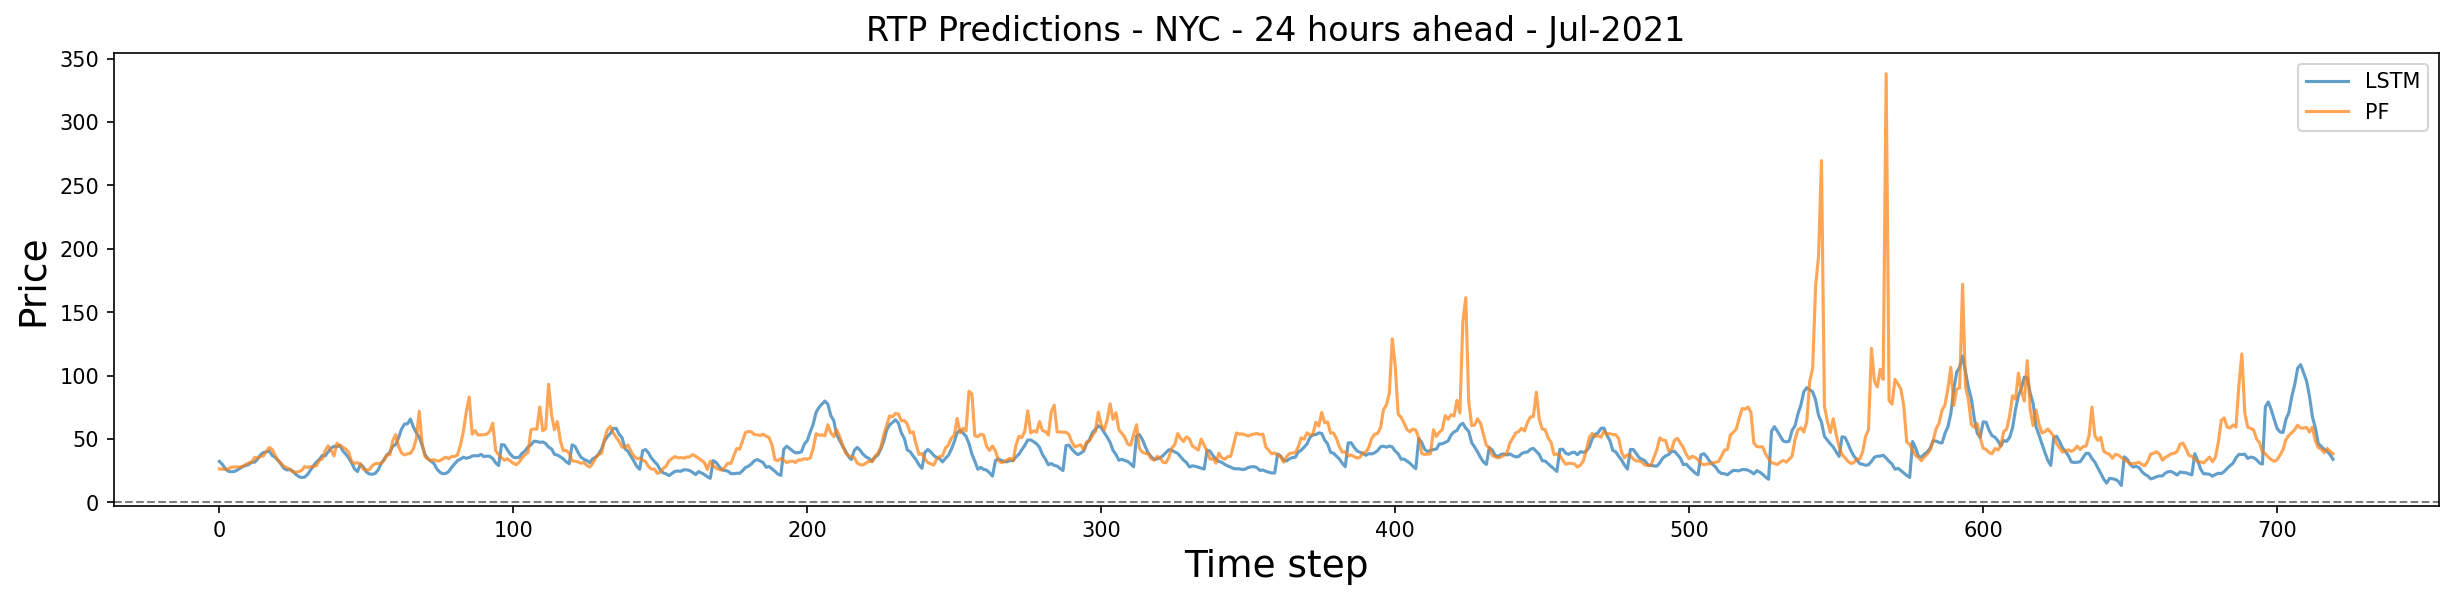

In [48]:
i = 7*24*30
j = i + 24*30

plot_predictions(y_test_pred_invlog[i:j,0].flatten(),
               y_test_cnn_lstm_invlog[i:j,0,0].flatten(),
               'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions(y_test_pred_invlog[i:j:24,:].flatten(),
               y_test_cnn_lstm_invlog[i:j:24,:].flatten(),
               'RTP Predictions - NYC - 24 hours ahead - Jul-2021')
